In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
#from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/COVID-19_Radiography_Dataset'

In [5]:
# #load training and testing dataset from output directory where the split is fixed for all models
# train_datagen=ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=15,
#                                    fill_mode="nearest",
#                                    horizontal_flip = True)
# valid_datagen=ImageDataGenerator(rescale = 1./255)
# test_datagen=ImageDataGenerator(rescale = 1./255)

# training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/train',
#                                                  target_size = (224, 224),
#                                                  batch_size = 64,
#                                                  class_mode = 'categorical',
#                                                  shuffle=True)
# valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/val',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)
# test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/test',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)

In [6]:
!pip install split-folders
import splitfolders
input_folder = '/content/drive/MyDrive/New_DS/Dataset_Covid/COVID-19_Radiography_Dataset'
splitfolders.ratio( input_folder,
                   output="output",seed=1337,ratio=(0.7,0.2,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 21168 files [06:33, 53.76 files/s] 


In [7]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 14816 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [8]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


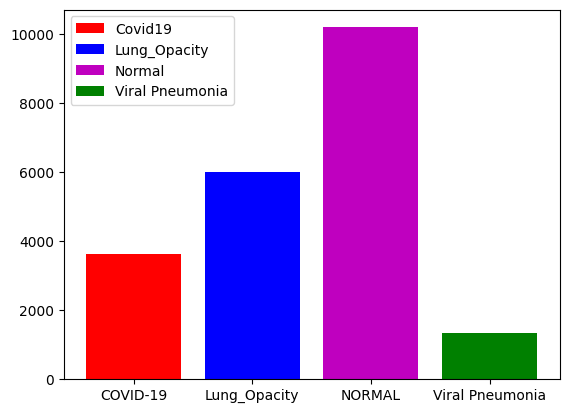

In [9]:
#visulaize data
fig, ax = plt.subplots()
ax.bar("COVID-19",3616,color="r",label="Covid19")
ax.bar("Lung_Opacity",6012 ,color="b",label="Lung_Opacity")
ax.bar("NORMAL",10192,color="m",label="Normal")
ax.bar("Viral Pneumonia",1345,color="g",label="Viral Pneumonia")
ax.legend()

In [10]:
from keras.applications.vgg16 import VGG16
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

VgModel = baseModel.output
VgModel = AveragePooling2D()(VgModel)
VgModel = Flatten()(VgModel)
VgModel = Dense(128, activation="relu")(VgModel)
VgModel = Dropout(0.2)(VgModel)
VgModel = Dense(4, activation='softmax')(VgModel)

VGG16_MODEL = Model(inputs=baseModel.input, outputs=VgModel)

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, AveragePooling2D, Flatten, Input, Lambda
from keras.applications.vgg16 import VGG16

def eca_module(inputs):
    channels = inputs.shape[-1]
    gamma = 2.0 # scaling parameter
    t = int(channels // gamma) # reduction ratio
    x = GlobalAveragePooling2D()(inputs) # global average pooling
    x = Dense(t, activation="relu")(x) # reduce dimensionality
    x = Dense(channels, activation="sigmoid")(x) # channel attention
    x = inputs * x[:, None, None, :]  # apply channel attention
    return x

baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

VgModel = baseModel.output
VgModel = AveragePooling2D()(VgModel)

# ECA Module
VgModel = (eca_module)(VgModel) # add the ECA module here

VgModel = Flatten()(VgModel)
VgModel = Dense(128, activation="relu")(VgModel)
VgModel = Dropout(0.2)(VgModel)
VgModel = Dense(4, activation='softmax')(VgModel)

VGG16_MODEL = Model(inputs=baseModel.input, outputs=VgModel)

In [12]:
VGG16_MODEL.compile(optimizer= tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
VGG16_MODEL.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [13]:
tf.keras.callbacks.ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

In [14]:
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [15]:
epochs = 100
initial_learning_rate=0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=initial_learning_rate / epochs)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [16]:
VGG16_MODEL.compile(optimizer = optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = VGG16_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])

<ipython-input-16-2e14b9070e18>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = VGG16_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])


Epoch 1/100
232/232 [==============================] - 262s 1s/step - loss: 0.6010 - accuracy: 0.7735 - precision: 0.8288 - recall: 0.7059 - val_loss: 0.4287 - val_accuracy: 0.8446 - val_precision: 0.8702 - val_recall: 0.8127
Epoch 2/100
232/232 [==============================] - 228s 984ms/step - loss: 0.4108 - accuracy: 0.8502 - precision: 0.8693 - recall: 0.8239 - val_loss: 0.3610 - val_accuracy: 0.8658 - val_precision: 0.8861 - val_recall: 0.8474
Epoch 3/100
232/232 [==============================] - 225s 969ms/step - loss: 0.3743 - accuracy: 0.8624 - precision: 0.8773 - recall: 0.8442 - val_loss: 0.3223 - val_accuracy: 0.8824 - val_precision: 0.8952 - val_recall: 0.8701
Epoch 4/100
232/232 [==============================] - 227s 978ms/step - loss: 0.3463 - accuracy: 0.8732 - precision: 0.8872 - recall: 0.8581 - val_loss: 0.3272 - val_accuracy: 0.8807 - val_precision: 0.8906 - val_recall: 0.8658
Epoch 5/100
232/232 [==============================] - 227s 978ms/step - loss: 0.3355 -

In [17]:
VGG16_MODEL.evaluate(test_set, verbose=1)
#***model.evaluate(test_set)

34/34 [==============================] - 11s 323ms/step - loss: 0.2921 - accuracy: 0.8952 - precision: 0.9045 - recall: 0.8853


[0.29212039709091187,
 0.8952335715293884,
 0.9045323133468628,
 0.8853232860565186]

In [18]:
VGG16_MODEL.save('VGG16.h5')

In [19]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     #history2.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [20]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.7734881043434143, 0.8501619696617126, 0.8623785376548767, 0.873245120048523, 0.8776997923851013, 0.883909285068512, 0.8853941559791565, 0.8903212547302246, 0.8923460841178894, 0.8944384455680847, 0.8937634825706482, 0.8946409225463867, 0.8950458765029907, 0.895788311958313, 0.8986905813217163, 0.8970707058906555, 0.8989605903625488, 0.9003104567527771, 0.8978132009506226]
validation accuracy:  [0.8445546627044678, 0.8658162355422974, 0.8823529481887817, 0.8806992769241333, 0.8854240775108337, 0.888495147228241, 0.8901488184928894, 0.8920387625694275, 0.8962910175323486, 0.8979447484016418, 0.8974722623825073, 0.8977084755897522, 0.8974722623825073, 0.8986534476280212, 0.8979447484016418, 0.8972359895706177, 0.8974722623825073, 0.8984171748161316, 0.8986534476280212]
loss:  [0.6010319590568542, 0.4108321964740753, 0.37433186173439026, 0.3462981879711151, 0.33552202582359314, 0.3226567804813385, 0.3146132826805115, 0.3053383529186249, 0.30239254236221313, 0.297096848487854,

Text(0.5, 1.0, 'Training and Validation Accuracy')

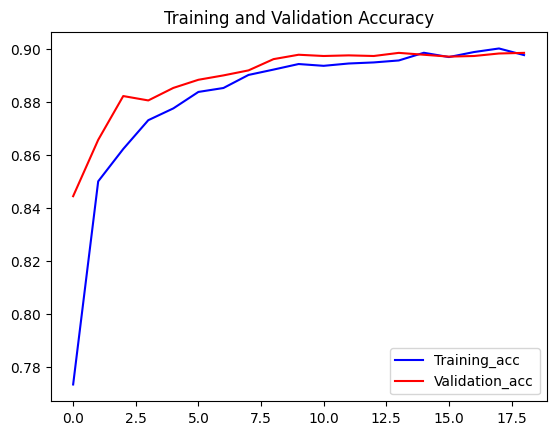

In [21]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

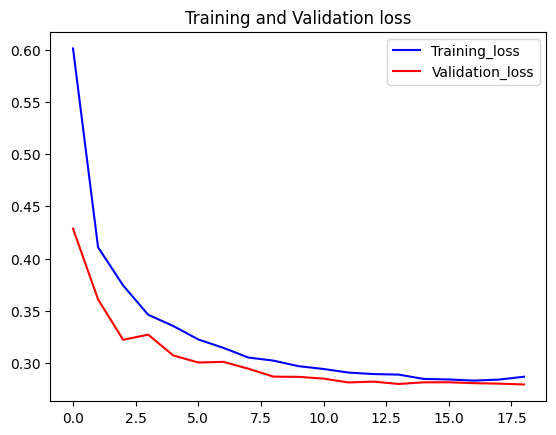

In [22]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

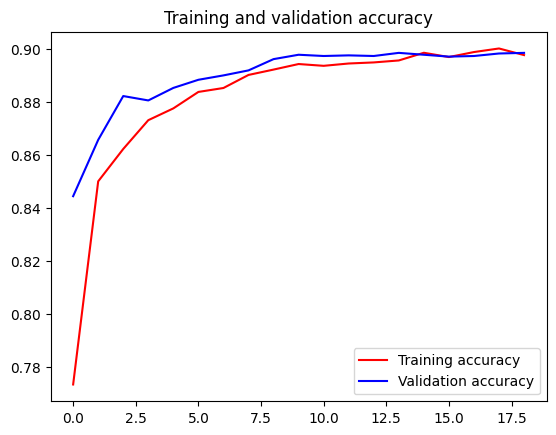

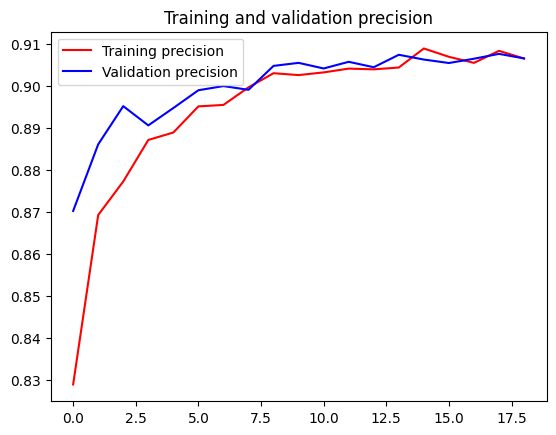

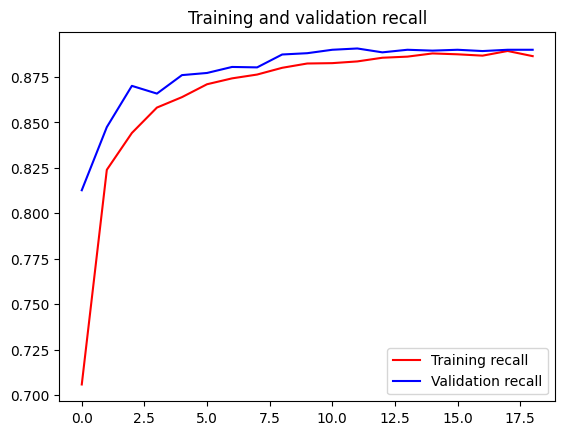

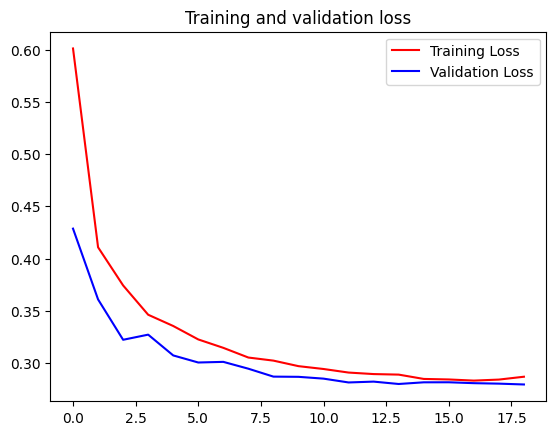

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
#model history
import pandas as pd
loss_df = pd.DataFrame(VGG16_MODEL.history.history)
loss_df

""


In [25]:
#prediction on test data
predictions = np.argmax(VGG16_MODEL.predict(test_set), axis = -1)

34/34 [==============================] - 10s 287ms/step


In [26]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       362
           1       0.89      0.86      0.88       602
           2       0.89      0.93      0.91      1020
           3       0.95      0.89      0.92       135

    accuracy                           0.90      2119
   macro avg       0.90      0.88      0.89      2119
weighted avg       0.90      0.90      0.89      2119



In [27]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[310  16  34   2]
 [ 19 517  66   0]
 [ 22  44 950   4]
 [  2   1  12 120]]
sensitivity: 0.9509
specificity: 0.9646


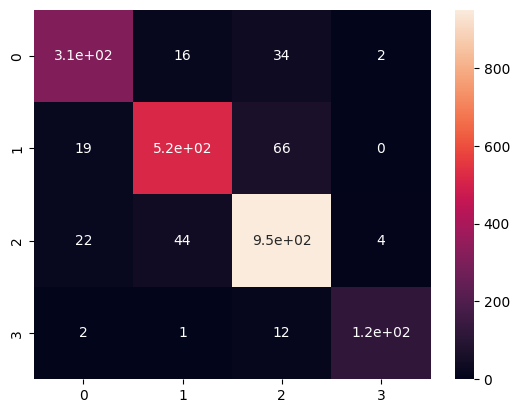

In [28]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [29]:
from numpy import sqrt
G_Mean = sqrt(sensitivity * specificity)
print("G_Mean: ", G_Mean)

G_Mean:  0.9577119878258333


In [30]:
True_Positive_Rate = cm[0, 0] / (cm[0, 0] + cm[0, 1])
False_Positive_Rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])
print("True_Positive_Rate: {:.4f}".format(True_Positive_Rate))
print("False_Positive_Rate: {:.4f}".format(False_Positive_Rate))

True_Positive_Rate: 0.9509
False_Positive_Rate: 0.0354


In [31]:
print(test_set)
print(predictions)

[0 0 0 ... 3 3 3]


In [32]:
testsetTo = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(testsetTo.shape)

(2119, 4)


In [33]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [34]:
#ROC-AUC Curve
# Learn to predict each class against the other
n_classes = 4 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
lw = 2 
for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [35]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-36-8d057ad44288>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


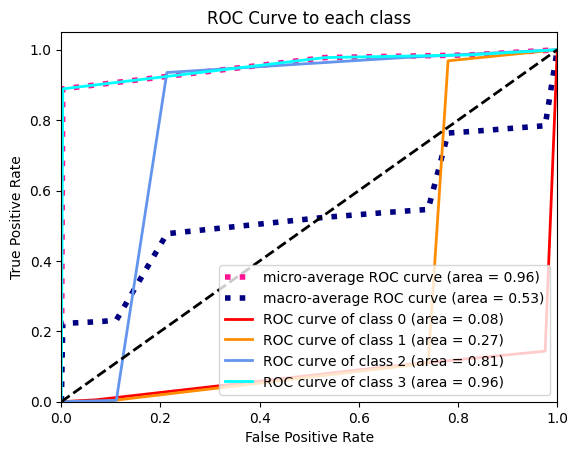

In [36]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'darkorange', 'cornflowerblue', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    roc_auc_scores.append(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve to each class')
plt.legend(loc="lower right")
plt.show()